## 10.5 使用PPO算法优化CartPole游戏
很多强化学习通过梯度上升的方法来最大化目标函数，使得策略最优。但是这种算法有一个明显的缺点：当策略网络是深度模型时，沿着策略梯度更新参数，很有可能由于步长太长，策略突然显著变差，进而影响训练效果。一种有效的解决方法是信任区域策略优化（trust region policy optimization，TRPO);然而TRPO的计算过程非常复杂，每一步更新的运算量非常大，进而其改进版算法PPO被提出。主流的PPO有两种，PPO-Penalty和PPO-Clip，但大量的实验表明PPO-Clip要更优秀一些，因此本项目采用PPO-Clip方法。
本项目基于OpenAI 的gym 环境，利用PPO算法完成车杆游戏（Cart Pole），游戏模型如图10-9所示。为便于大家更好理解，动作空间为离散的情况（对连续环境，只需稍作修改即可）。游戏里面有一个小车，上有竖着一根杆子，每次重置后的初始状态会有所不同。小车需要左右移动来保持杆子竖直，游戏目标是左右移动小车将黄色的杆子保持竖直。动作维度为2，属于离散值；状态维度为 4，分别是坐标、速度、角度、角速度。
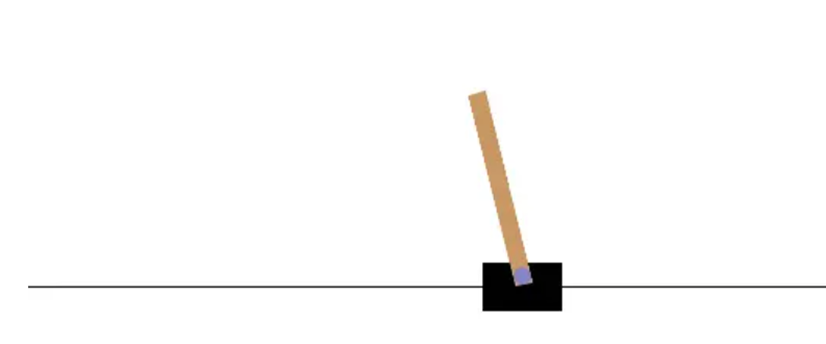
<center>图10-9  车杆游戏示意图</center>
策略网络输出为softmax函数，对应$\pi(a|s;\theta)$

### 10.5.1构建策略网络、### 10.5.2 构建价值网络、### 10.5.3构建PPO模型
PPO算法用到了两个网络：策略网络,价值网络(actor-critic)。PPO是同步策略（on-policy），交互的策略由策略网络直接生成。

In [1]:
# 代码用于离散环境的模型
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
# ----------------------------------- #
# 构建策略网络--actor
# ----------------------------------- #

class PolicyNet(nn.Module):
    def __init__(self, n_states, n_hiddens, n_actions):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(n_states, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_actions)
    def forward(self, x):
        x = self.fc1(x)  # [b,n_states]-->[b,n_hiddens]
        x = F.relu(x)
        x = self.fc2(x)  # [b, n_actions]
        x = F.softmax(x, dim=1)  # [b, n_actions]  计算每个动作的概率
        return x

# ----------------------------------- #
# 构建价值网络--critic
# ----------------------------------- #

class ValueNet(nn.Module):
    def __init__(self, n_states, n_hiddens):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(n_states, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, 1)
    def forward(self, x):
        x = self.fc1(x)  # [b,n_states]-->[b,n_hiddens]
        x = F.relu(x)
        x = self.fc2(x)  # [b,n_hiddens]-->[b,1]  评价当前的状态价值state_value
        return x

# ----------------------------------- #
# 构建模型
# ----------------------------------- #

class PPO:
    def __init__(self, n_states, n_hiddens, n_actions,
                 actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        # 实例化策略网络
        self.actor = PolicyNet(n_states, n_hiddens, n_actions).to(device)
        # 实例化价值网络
        self.critic = ValueNet(n_states, n_hiddens).to(device)
        # 策略网络的优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        # 价值网络的优化器
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)

        self.gamma = gamma  # 折扣因子
        self.lmbda = lmbda  # GAE优势函数的缩放系数
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    # 动作选择
    def take_action(self, state):
        # 维度变换 [n_state]-->tensor[1,n_states]
        state = torch.tensor(state[np.newaxis, :]).to(self.device)
        # 当前状态下，每个动作的概率分布 [1,n_states]
        probs = self.actor(state)
        # 创建以probs为标准的概率分布
        action_list = torch.distributions.Categorical(probs)
        # 依据其概率随机挑选一个动作
        action = action_list.sample().item()
        return action

    # 训练
    def learn(self, transition_dict):
        # 提取数据集
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).to(self.device).view(-1,1)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).to(self.device).view(-1,1)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).to(self.device).view(-1,1)

        # 目标，下一个状态的state_value  [b,1]
        next_q_target = self.critic(next_states)
        # 目标，当前状态的state_value  [b,1]
        td_target = rewards + self.gamma * next_q_target * (1-dones)
        # 预测，当前状态的state_value  [b,1]
        td_value = self.critic(states)
        # 目标值和预测值state_value之差  [b,1]
        td_delta = td_target - td_value

        # 时序差分值 tensor-->numpy  [b,1]
        td_delta = td_delta.cpu().detach().numpy()
        advantage = 0  # 优势函数初始化
        advantage_list = []

        # 计算优势函数
        for delta in td_delta[::-1]:  # 逆序时序差分值 axis=1轴上倒着取 [], [], []
            # 优势函数GAE的公式
            advantage = self.gamma * self.lmbda * advantage + delta
            advantage_list.append(advantage)
        # 正序
        advantage_list.reverse()
        # numpy --> tensor [b,1]
        advantage = torch.tensor(advantage_list, dtype=torch.float).to(self.device)

        # 策略网络给出每个动作的概率，根据action得到当前时刻下该动作的概率
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        # 一组数据训练 epochs 轮
        for _ in range(self.epochs):
            # 每一轮更新一次策略网络预测的状态
            log_probs = torch.log(self.actor(states).gather(1, actions))
            # 新旧策略之间的比例
            ratio = torch.exp(log_probs - old_log_probs)
            # 近端策略优化裁剪目标函数公式的左侧项
            surr1 = ratio * advantage
            # 公式的右侧项，ratio小于1-eps就输出1-eps，大于1+eps就输出1+eps
            surr2 = torch.clamp(ratio, 1-self.eps, 1+self.eps) * advantage

            # 策略网络的损失函数
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            # 价值网络的损失函数，当前时刻的state_value - 下一时刻的state_value
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))

            # 梯度清0
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            # 反向传播
            actor_loss.backward()
            critic_loss.backward()
            # 梯度更新
            self.actor_optimizer.step()
            self.critic_optimizer.step()


### 10.5.4 设置参数、10.5.5 实例化模型、10.5.6 训练模型、10.5.7 可视化迭代
定义一些超参数代码如下：

C:\Users\wumgapp\AppData\Local\Temp\ipykernel_17932\4248003697.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)


iter:0, return:21.0
iter:1, return:30.5
iter:2, return:24.666666666666668
iter:3, return:32.25
iter:4, return:29.2
iter:5, return:29.666666666666668
iter:6, return:29.428571428571427
iter:7, return:31.875
iter:8, return:30.333333333333332
iter:9, return:28.7
iter:10, return:28.3
iter:11, return:27.1
iter:12, return:29.3
iter:13, return:26.3
iter:14, return:31.9
iter:15, return:31.2
iter:16, return:32.2
iter:17, return:34.1
iter:18, return:36.7
iter:19, return:37.2
iter:20, return:37.5
iter:21, return:45.9
iter:22, return:46.0
iter:23, return:45.3
iter:24, return:39.2
iter:25, return:40.2
iter:26, return:41.3
iter:27, return:39.4
iter:28, return:37.7
iter:29, return:39.0
iter:30, return:38.3
iter:31, return:30.2
iter:32, return:30.2
iter:33, return:34.2
iter:34, return:46.7
iter:35, return:45.4
iter:36, return:42.2
iter:37, return:44.1
iter:38, return:44.4
iter:39, return:44.6
iter:40, return:47.0
iter:41, return:51.2
iter:42, return:52.5
iter:43, return:50.8
iter:44, return:42.9
iter:4

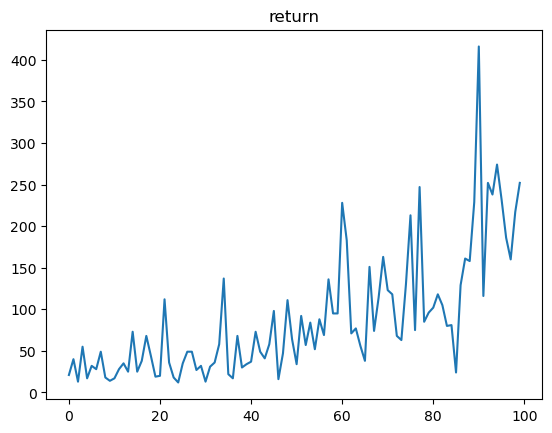

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# ----------------------------------------- #
# 参数设置
# ----------------------------------------- #

num_episodes = 100  # 总迭代次数
gamma = 0.9  # 折扣因子
actor_lr = 1e-3  # 策略网络的学习率
critic_lr = 1e-2  # 价值网络的学习率
n_hiddens = 16  # 隐含层神经元个数
env_name = 'CartPole-v1'
return_list = []  # 保存每个回合的return

# ----------------------------------------- #
# 环境加载
# ----------------------------------------- #

env = gym.make(env_name, render_mode="human")
n_states = env.observation_space.shape[0]  # 状态数 4
n_actions = env.action_space.n  # 动作数 2

# ----------------------------------------- #
# 模型构建
# ----------------------------------------- #

agent = PPO(n_states=n_states,  # 状态数
            n_hiddens=n_hiddens,  # 隐含层数
            n_actions=n_actions,  # 动作数
            actor_lr=actor_lr,  # 策略网络学习率
            critic_lr=critic_lr,  # 价值网络学习率
            lmbda = 0.95,  # 优势函数的缩放因子
            epochs = 10,  # 一组序列训练的轮次
            eps = 0.2,  # PPO中截断范围的参数
            gamma=gamma,  # 折扣因子
            device = device
            )

# ----------------------------------------- #
# 训练--回合更新 on_policy
# ----------------------------------------- #

for i in range(num_episodes):

    state = env.reset()[0]  # 环境重置
    done = False  # 任务完成的标记
    episode_return = 0  # 累计每回合的reward

    # 构造数据集，保存每个回合的状态数据
    transition_dict = {
        'states': [],
        'actions': [],
        'next_states': [],
        'rewards': [],
        'dones': [],
    }

    while not done:
        action = agent.take_action(state)  # 动作选择
        next_state, reward, done, _, _  = env.step(action)  # 环境更新
        # 保存每个时刻的状态动作...
        transition_dict['states'].append(state)
        transition_dict['actions'].append(action)
        transition_dict['next_states'].append(next_state)
        transition_dict['rewards'].append(reward)
        transition_dict['dones'].append(done)
        # 更新状态
        state = next_state
        # 累计回合奖励
        episode_return += reward

    # 保存每个回合的return
    return_list.append(episode_return)
    # 模型训练
    agent.learn(transition_dict)

    # 打印回合信息
    print(f'iter:{i}, return:{np.mean(return_list[-10:])}')
    
print('循环完成')
env.render() # 图像引擎
env.close() # 关闭环境

# -------------------------------------- #
# 绘图
# -------------------------------------- #

plt.plot(return_list)
plt.title('return')
plt.show()